# **CHAPTER03.분류**

## **3.1 MNIST**

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

C:\anaconda\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

사이킷런에서 읽어 드린 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 가짐
- 데이터셋을 설명하는 DESCR 키
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
- 레이블 배열을 담은 target 키

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

- 이미지가 70,000개 있고 각 이미지에는 784개의 특성이 있음 <= 이미지가 28 x 28 픽셀이기 때문
- 개개의 특성은 0 (흰색)부터 255 (검은색)까지의 픽셀 강도를 나타냄

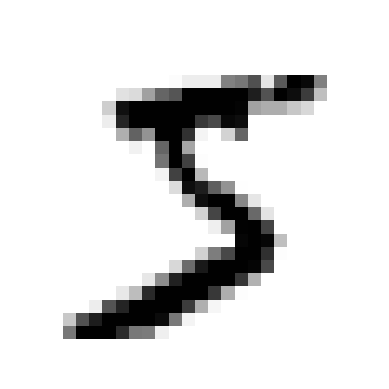

In [5]:
# 데이터셋에서 이미지 하나를 확인해보자
# 샘플의 특성 벡터 추출 => 28 x 28 배열로 크기 변환 => 맷플롯립의 imshow() 함수 사용해 그리기

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

In [6]:
# 그림은 숫자 5로 보임. 실제 레이블 확인.
y[0]

'5'

In [7]:
# 레이블은 문자열
# 대부분 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환
import numpy as np
y = y.astype(np.uint8)

- 데이터를 자세히 조사하기 전, 항상 테스트 세트를 만들고 따로 떼어놓아야 함
- MNIST 데이터셋은 이미 훈련 세트 (앞쪽 60,000개 이미지)와 테스트 세트 (뒤쪽 10,000개 이미지)로 나누어놓음

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

- 훈련 세트는 이미 섞여 있어서 모든 교차 검증 폴드를 비슷하게 만듦 (하나의 폴드라도 특정 숫자가 누락되면 안 됨)
- 어떤 학습 알고리즘은 훈련 샘플의 순서에 민감해서 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠짐  
  => 데이터셋을 섞으면 이런 문제 방지 가능

## **3.2 이진 분류기 훈련**

5만 식별하는 감지기: '5'와 '5 아님' 두 개의 클래스를 구분할 수 있는 이진 분류기의 한 예시

In [9]:
# 분류 작업을 위해 타깃 벡터 만들기

y_train_5  = (y_train == 5)     # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

이제 분류 모델을 하나 선택해서 훈련시키자
- 사이킷런의 SGDClassifier 클래스를 사용해 확률적 경사 하강법(SGD: Stochastic Gradient Descent) 분류기로 시작해보는 것도 좋음  
  => 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문에 매우 큰 데이터셋을 효율적으로 처리하는 장점

In [10]:
# SGDClassifier 모델을 만들고 전체 훈련 세트를 사용해 훈련시켜보자

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

SGDClassifier는 훈련하는 데 무작위성 사용 (그래서 이름에 '확률적'이 붙음)  
=> 결과를 재현하고 싶다면 random_state 매개변수를 지정해야 함

In [11]:
# 이제 이 모델을 사용해 숫자 5의 이미지를 감지해보자

sgd_clf.predict([some_digit])

array([ True])

분류기는 이 이미지가 5를 나타낸다고 추측함 (True)

## **3.3 성능 측정**

분류기 평가는 회귀 모델보다 훨씬 어려우며 사용할 수 있는 성능 지표가 많음

### **3.3.1 교차 검증을 사용한 정확도 측정**

- 가끔 사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 필요가 있음
- 이 때는 교차 검증 기능을 직접 구현하면 됨

In [12]:
# 다음 코드는 사이킷런의 cross_val_score() 함수와 거의 같은 작업을 수행하고 동일한 결과를 출력함

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))     # 0.9502, 0.96565, 0.96495 출력

0.95035
0.96035
0.9604


- StratifiedKFold는 클래스별 비율이 유지되도록 만들기 위해 계층적 샘플링 수행
- 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만듦
- 그런 다음 올바른 예측의 수를 세어 정확한 예측의 비율 출력

- cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델을 평가해보자
- k-겹 교차 검증: 훈련 세트를 k개(여기서는 3개)의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

- 모든 교차 검증 폴드에 대해 정확도가 95% 이상
- 이제 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교해보자

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

- 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측하면 정확히 맞출 확률이 90%
- 이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줌
- 특히 불균형한 데이터셋을 다룰 때 (즉, 어떤 클래스가 다른 것보다 월등히 많은 경우) 더욱 적합하지 않음

### **3.3.2 오차 행렬**

- 분류기의 성능을 평가하 더 좋은 방법: 오차 행렬 confusion matrix를 조사
- 기본적인 아이디어: 클래스 A의 샘플이 클래스 B로 분류된 횟수 세기
- e.g.) 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면, 오차 행렬의 5행 3열 확인
- 오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 함
- 테스트 세트로 예측을 만들 수 있지만 여기서 사용하면 안 됨 (테스트 세트는 분류기가 출시 준비를 마치고 나서 프로젝트의 맨 마지막에 사용됨)
- 대신 cross_val_predict() 함수 사용 가능

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

- cross_val_score() 함수처럼 cross_val_predict() 함수는 k-겹 교차 검증 수행
- BUT 평가 점수를 반환하지 않고, 각 테스트 폴드에서 얻은 예측을 반환
- 즉, 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 됨 (모델이 훈련하는 동안 보지 못했던 데이터에 대해 예측)

- 이제 confusion_matrix() 함수를 사용해 오차 행렬을 만들어보자

In [17]:
# 타깃 클래스 (y_train_5)와 예측 클래스 (y_train_pred)를 넣고 호출하기

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

- 오차 행렬의 행: 실제 클래스
- 오차 행렬의 열: 예측한 클래스
- 이 행렬의 첫 번째 행: '5 아님' 이미지 (음성 클래스)에 대한 것으로, 53057개를 '5 아님'으로 정확하게 분류함 (진짜 음성), 나머지 1522개는 '5'라고 잘못 분류함 (거짓 양성)
- 이 행렬의 두 번째 행: '5' 이미지 (양성 클래스)에 대한 것으로, 1325개를 '5 아님'으로 잘못 분류했고 (거짓 음성), 나머지 4096개를 정확히 '5'라고 분류함 (진짜 양성)
- 완벽한 분류기라면: 진짜 양성과 진짜 음성만 가지고 있을 것이므로 오차 행렬의 주대각선 (왼쪽 위에서 오른쪽 아래로)만 0이 아닌 값이 됨

In [18]:
y_train_perfect_predictions = y_train_5     # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

- 오차 행렬이 많은 정보를 제공해주지만 가끔 더 요약된 지표가 필요할 때도 있음
- 양성 예측의 정확도 = 분류기의 '정밀도' (precision) = TP/(TP+FP)
- TP: 진짜 양성의 수
- FP: 거짓 양성의 수

- 확실한 양성 샘플 하나만 예측하면 간단히 완벽한 정밀도를 얻을 수 있지만 (정밀도 = 1/1 = 100%)
- 이는 분류기가 다른 모든 양성 샘플을 무시하기 때문에 유용하지 X
- 정밀도는 재현율(recall)이라는 또 다른 지표와 같이 사용하는 것이 일반적
- 재현율 = 분류기가 정확하게 감지한 양성 샘플의 비율 = 민감도(sensitivity) = 진짜 양성 비율 (true positive rate, TPR) = TP/(TP+FN)

### **3.3.3 정밀도와 재현율**

- 사이킷런은 정밀도와 재현율을 포함하여 분류기의 지표를 계산하는 여러 함수 제공

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)     # == 4096/(4096+1522)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred)     # == 4096/(4096_1325)

0.6511713705958311

- 정밀도와 재현율을 'F1 score'라고 하는 하나의 숫자로 만들면 편리
- 특히 두 분류기를 비교할 때 편리
- F1 점수 = 정밀도와 재현율의 조화 평균 (harmonic mean)  
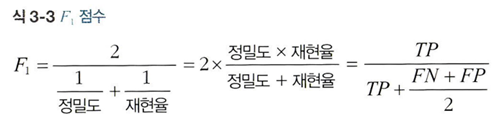
- F1 점수를 계산하려면 f1_score() 함수 호출

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

- 정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높음 BUT 이게 항상 바람직한 건 아님
- 상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있음
- eg) 어린아이에게 안전한 동영상을 걸러내는 분류기 훈련: 재현율은 높으나 정말 나쁜 동영상이 몇 개 노출되는 것보다 좋은 동영상이 많이 제외되더라도 (낮은 재현율) 안전한 것들만 노출시키는 (높은 정밀도) 분류기 선호
- 정밀도와 재현율을 모두 잡을 수는 없음: 정밀도를 올리면 재현율이 줄고 vice versa: 정밀도/재현율 트레이드오프

### **3.3.4 정밀도/재현율 트레이드오프**

- SGDClassifier 분류기는 결정 함수 decision functions를 사용하여 각 샘플의 점수 계산
- 이 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당, 그렇지 않으면 음성 클래스에 할당
- 사이킷런에서 임곗값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인 가능
- 분류기의 predict() 메서드 대신 decision_function() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있음

In [22]:
# 이 점수를 기반으로 원하는 임곗값을 정해 예측 만들기

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

- SGDClassifier의 임곗값이 0이므로 위 코드는 predict() 메서드와 같은 결과, 즉 True를 반환

In [24]:
# 임곗값 높여보자

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

- 임곗값을 높이면 재현율이 줄어듦을 확인
- 이미가 실제로 숫자 5이고 임곗값이 0일 때는 분류기가 이를 감지했지만, 임곗값을 8000으로 높이면 이를 놓침
- 적절한 임곗값은 어떻게 설정?
- 먼저, cross_val_predict() 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야 함
- BUT 이번에는 예측 결과가 아니라 결정 점수를 반환받도록 지정해야 함

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

- 이 점수로 precision_recall_curve() 함수를 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율 계산 가능

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

- 이제 맷플롯립을 이용해 임곗값의 함수로 정밀도와 재현율을 그릴 수 있음

C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44247 (\N{HANGUL SYLLABLE GYES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 

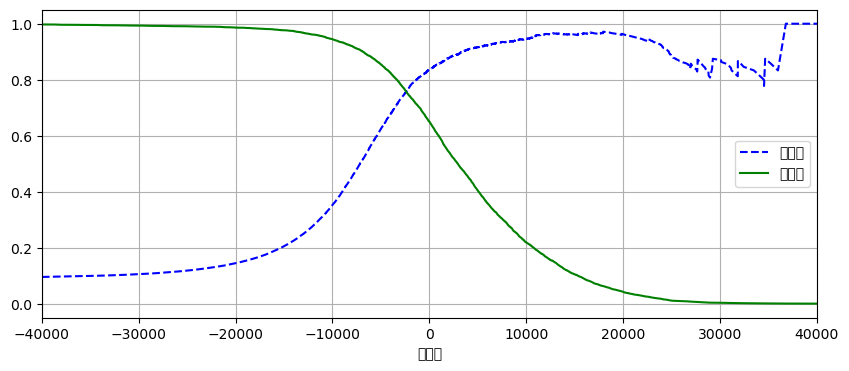

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.figure(figsize=(10,4))
  plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
  plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
  plt.xlabel("임곗값")
  plt.xlim(-40000, 40000)
  plt.legend()
  plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
     

- 좋은 정밀도/재현율 트레이드오프를 선택하는 다른 방법: 아래와 같이 재현율에 대한 정밀도 곡선 그리기  
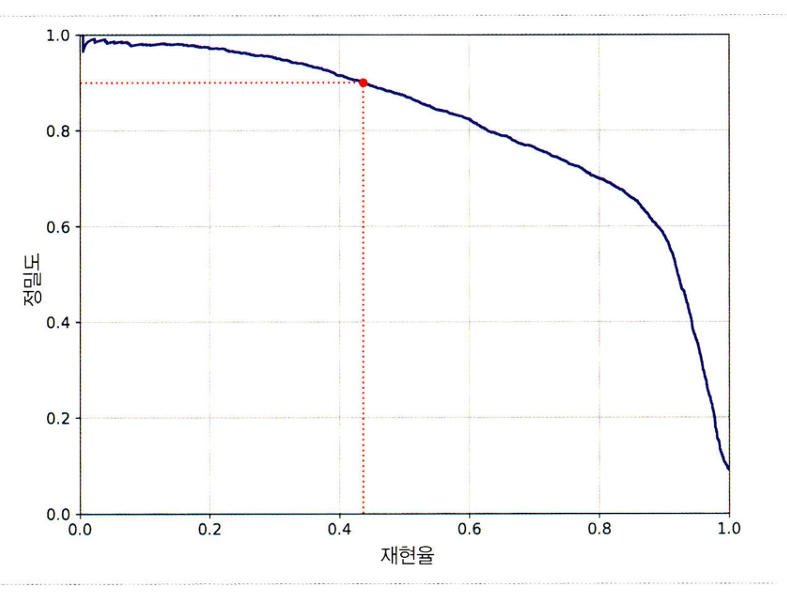

- 재현율 80% 근처에서 정밀도가 급격하게 줄기 시작
- 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋음 (eg. 재현율 60% 지점)
- 정밀도 90% 달성이 목표라고 한다면, 위의 맷플롯립 이용해 그린 그래프에서 임곗값이 약 8000 정도임을 알 수 있음

In [28]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816

In [62]:
# (훈련 세트에 대한) 예측을 만들려면 분류기의 predict() 메서드를 호출하는 대신 다음 코드 실행
y_train_pred_90 = (y_scores >= threshold_90_precision)

- 이 예측에 대한 정밀도와 재현율 확인

In [30]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [31]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

- 이처럼 어떤 가상의 정밀도에 대해서도 분류기를 손쉽게 만들 수 있음
- 충분히 큰 임곗값을 지정하면 됨
- 또한 재현율과 정밀도 모두가 어느 정도 높은 값을 가져야 함

### **3.3.5 ROC 곡선**

- 수신기 조작 특성 (receiver operating characteristic, ROC) 곡선도 이진 분류에서 널리 사용하는 도구
- 정밀도/재현율 곡선과 매우 유사
- BUT ROC 곡선은 정밀도에 대한 재현율 곡선이 아니라, 거짓 양성 비율 (FPR)에 대한 진짜 양성 비율 (TPR) 곡선임
- FPR = 1 - TNR(진짜 음성 비율)
- TNR을 특이도(specificity)라고도 함
- 따라서 ROC 곡선은 민감도(재현율)에 대한 1-특이도 그래프
- ROC 곡선을 그리려면, 먼저 roc_curve() 함수를 사용해 여러 임곗값에서 TPR과 FPR을 계산해야 함

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

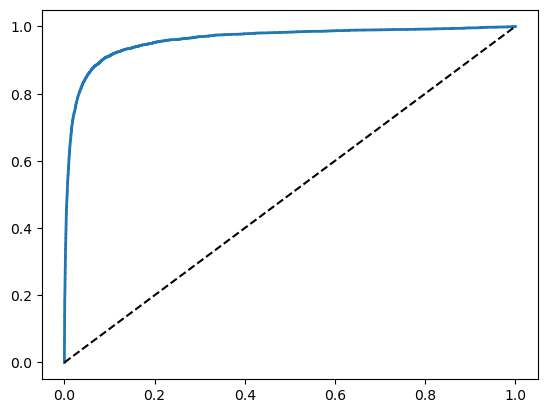

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--') # 대각 점선

plot_roc_curve(fpr, tpr)
plt.show()

- 여기서도 트레이드 오프 존재: 재현율이 높을수록 분류기가 만드는 거짓 양성이 늘어남
- 점선: 완전한 랜덤 분류기의 ROC 곡선
- 즉, 좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 함
- 따라서 곡선 아래의 면적 (area under the curve, AUC)을 측정하면 분류기들을 비교 가능
- 완벽한 분류기: ROC의 AUC가 1
- 완전한 랜덤 분류기: ROC의 AUC가 0.5
- 사이킷런은 ROC의 AUC를 계산하는 함수 제공

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

- RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC곡선과 ROC AUC 점수를 비교해보자
- 먼저 훈련 세트의 샘플에 대한 점수를 얻어야 함
- BUT 작동 방식의 차이로 인해 RandomForestClassifier에는 decision_function() 메서드가 없음
- 대신 predict_proba() 메서드 존재
- 사이킷런 분류기는 일반적으로 이 두 메서드 중 하나 또는 둘 모두를 가지고 있음
- predict_proba() 메서드는 샘플이 행, 클래스가 열이고, 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [36]:
y_scores_forest = y_probas_forest[:, 1]     # 양성 클래스에 대한 확률을 점수로 사용합니다.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 53944 (\N

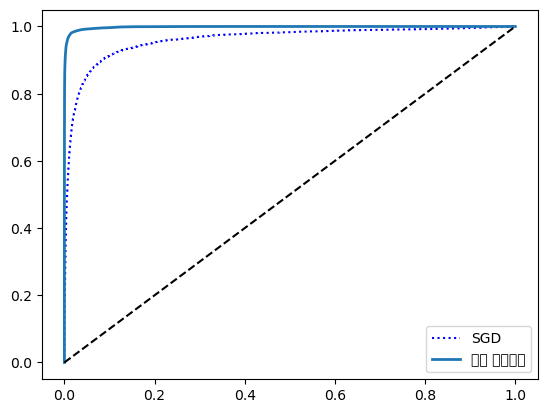

In [37]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

- RandomForestClassifier의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 SGDClassifier보다 훨씬 좋아 보임 (당연히 ROC AUC 점수도 훨씬 더 높음)

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## **3.4 다중 분류**

- 이진 분류가 두 개의 클래스를 구별하는 반면
- 다중 분류기 (multiclass classifier) 혹은 다항 분류기 (multinomial classifier)는 둘 이상의 클래스 구별 가능

- SGD 분류기, 랜덤 포레스트 분류기 같은 일부 알고리즘은 여러 개의 클래스를 직접 처리 가능
- BUT 로지스틱 회귀, 서포트 벡터 머신 분류기 같은 다른 알고리즘은 이진 분류만 가능
- BUT 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많음
- eg) 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개(0~9)를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만들 수 있음
- 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택  
  => OvR (one-versus-the-rest) 전략 또는 OvA (one-versus-all)
- 또 다른 전략은 0과 1 구별, 0과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시키는 것  
  => OvO (one-versus-one) 전략: 클래스가 N개라면 분류기는 N(N-1)/2개 필요
- OvO 전략의 주요 장점: 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요
- 서포트 벡터 머신 같은 일부 알고리즘은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇 개의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO 선호
- BUT 대부분의 이진 분류 알고리즘에서는 OvR 선호
- 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면, 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO 실행

In [39]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train[:2000], y_train[:2000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [40]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 3.79297828,  0.72949369,  6.06184129,  8.29800527, -0.29383983,
         9.30157597,  1.74723215,  2.77365456,  7.20601456,  4.82245092]])

In [41]:
np.argmax(some_digit_scores)

5

In [42]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [43]:
svm_clf.classes_[5]

5

- 사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier 사용
- 간단하게 이진 분류기 인스턴스를 만들어 객체를 생성할 때 전달하면 됨 (이진 분류기일 필요도 없음)

In [ ]:
# SVC 기반으로 OvR 전략을 사용하는 다중 분류기 만들기
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

In [45]:
len(ovr_clf.estimators_)

10

- SGDClassifier 또는 RandomForestClassifier를 훈련시키는 것도 간단

In [46]:
sgd_clf.fit(X_train[:2000], y_train[:2000])
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [47]:
sgd_clf.decision_function([some_digit])

array([[-1704540.26918897, -1683382.42678916, -2594122.50571131,
         -145667.7337014 , -3270741.36924448,    -4883.95058744,
        -3420127.24409032, -1846510.16554943, -1328858.01006284,
        -2043246.17459117]])

In [48]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## **3.5 에러 분석**

- 실제 프로젝트라면 머신러닝 프로젝트 체크리스트 (부록B)의 단계를 따를 것
- 데이터 준비 단계에서 가능한 선택 사항을 탐색 > 여러 모델 시도 > 가장 좋은 몇 개를 골라 GridSearchCV를 사용해 하이퍼파라미터를 세밀하게 튜닝 > 가능한 한 자동화
- 이 절에서는 가능성이 높은 모델을 하나 찾았다고 가정하고, 이 모델의 성능을 향상시킬 방법을 찾아보자
- 성능 향상의 한 가지 방법: 만들어진 에러의 종류 분석

- 먼저 오차 행렬을 살펴볼 수 있음

In [50]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

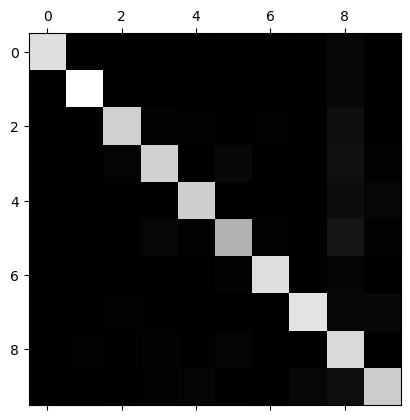

In [51]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

- 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아 보임
- 숫자 5는 다른 숫자보다 조금 더 어두워 보임
- 이는 데이터셋에 숫자 5의 이미가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻
- 따라서 두 경우에 대해 모두 확인해보아야 함

- 그래프의 에러 부분에 초점을 맞춰 보면,
- 먼저 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 (에러의 절대 개수가 아니라) 에러 비율을 비교 (개수로 비교 시 이미지가 많은 클래스가 상대적으로 나쁘게 보임)

In [52]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

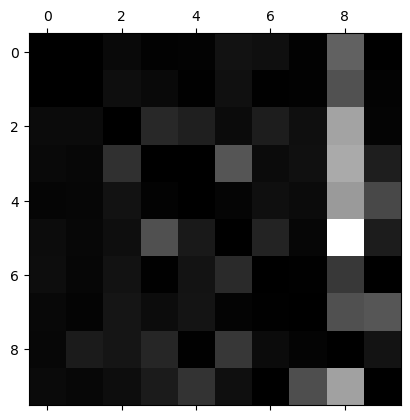

In [53]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- 여기서 분류기가 만든 에러를 확실히 볼 수 있음
- 행은 실제 클래스를 나타내고
- 열은 예측한 클래스를 나타냄
- 클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시함
- BUT 클래스 8의 행은 그리 나쁘지 않음
- 이는 실제 8이 적절히 8로 분류되었음을 알려줌
- 여기서 볼 수 있듯, 오차 행렬은 반드시 대칭인 것은 아님
- 3과 5가 서로 많이 혼동되고 있는 것도 볼 수 있음

- 오차 행렬을 분석하면 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있음
- 이 그래프를 살펴보면 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있음
- eg) 8처럼 보이지만 8이 아닌 숫자의 훈련 데이터를 더 많이 모아서 실제 8과 구분하도록 분류기를 학습시키기
- eg) 분류기에 도움 될 만한 특성을 더 찾아볼 수 있음: 동심원의 수를 세는 알고리즘 (8은 2개 6은 1개 5는 0개)

- 개개의 에러를 분석해보면 분류기가 무슨 일을 하고, 왜 잘못되었는지에 대한 통찰을 얻을 수 있지만, 더 어렵고 시간이 오래 걸림

In [54]:
import matplotlib.pyplot as plt
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다.
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

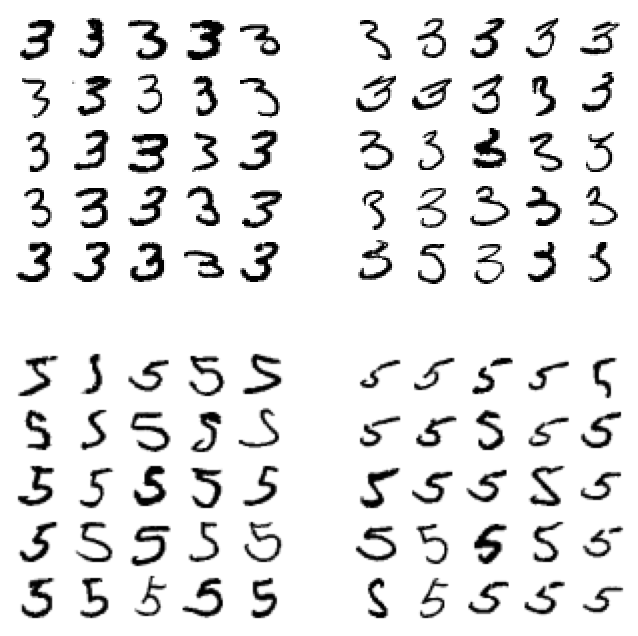

In [55]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train==cl_a) & (y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a) & (y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b) & (y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b) & (y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

- 왼쪽의 5x5 블록 두 개는 3으로 분류된 이미지
- 오른쪽 5x5 블록 두 개는 5로 분류된 이미지
- 분류기가 잘못 분류한 숫자 중 일부는 정말 잘못 쓰여 있어서 사람도 분류하기 어려움
- BUT 대부분의 잘못 분류된 이미지는 확실히 에러인 것 같고 분류기가 실수한 이유를 이해하기 어려움
- 원인: 선형 모델인 SGDClassifier를 사용했기 때문
- 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산
- 따라서 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동하게 됨

- 3과 5의 주요 차이는 위쪽 선과 아래쪽 호를 이어주는 작은 직선의 위치
- 숫자 3을 쓸 때 연결 부위가 조금 왼쪽으로 치우치면 분류기가 5로 분류하고, 반대도 마찬가지
- 즉, 분류기는 이미지의 위치나 회전 방향에 매우 민감
- 3과 5의 에러를 줄이는 방법: 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리. 이렇게 했을 때 아마 다른 에러도 줄어들 것.

## **3.6 다중 레이블 분류**

- 지금까지는 각 샘플이 하나의 클래스에만 할당되었음
- BUT 분류기가 샘플마다 여러 개의 클래스를 출력해야 할 때도 있음
- eg. 얼굴 인식 분류기: 같은 사진에 여러 사람이 등장한다면? 인식된 사람마다 하나씩 tag를 붙여야 함
- 이처럼 여러 개의 이진 꼬리표를 출력하는 분류시스템을 다중 레이블 분류 시스템이라고 함

In [56]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [57]:
knn_clf.predict([some_digit])

array([[False,  True]])

- 다중 레이블 분류기를 평가하는 방법은 많음
- 적절한 지표는 프로젝트에 따라 다름
- eg) 각 레이블의 F1 점수를 구하고 간단하게 평균 점수 계산

In [58]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

- 실제로는 아닐 수 있지만 이 코드는 모든 레이블의 가중치가 같다고 가정한 것
- 특히 앨리스 사진이 밥이나 찰리 사진보다 훨씬 많다면 앨리스 사진에 대한 분류기의 점수에 더 높은 가중치를 둘 것
- 간단한 방법은 클래스의 지지도 (support)를 가중치로 주는 것. 이렇게 하려면 이전 코드에서 average="weighted"로 설정하면 됨.

## **3.7 다중 출력 분류**

- 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것이 다중 출력 다중 클래스 분류, 혹은 간단히 다중 출력 분류

- 이를 위해 이미지에서 잡음을 제거하는 시스템을 만들어보자
- 잡음이 많은 숫자 이미지를 입력으로 받고, 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력
- 분류기의 출력이 다중 레이블(필셀당 한 레이블)이고 각 레이블은 값을 여러 개 가짐(0~255까지 픽셀 강도)  
  => 다중 출력 분류 시스템

In [59]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [60]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")
    plt.axis("off")

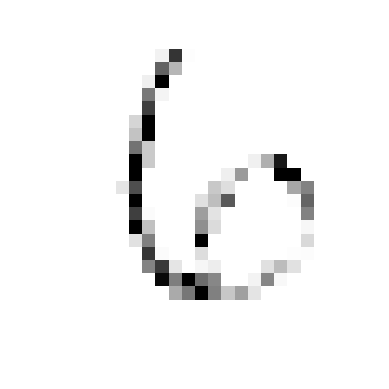

In [61]:
some_index = 100
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)